In [1]:
import pandas as pd
import geopandas
from matplotlib import pyplot as plt
from pyspark.sql import SparkSession
from spark_job_functions import spark_config
import os


In [2]:
iceberg_warehouse = os.environ.get('ICEBERG_WAREHOUSE')
spark = SparkSession.builder.config(conf=spark_config(iceberg_warehouse)).getOrCreate()

### Read in fact table and add geometry for plots

In [23]:
#read in fact & subject tables convert to pandasdf

#fact table
facts = spark.sql('SELECT * FROM nyt.db.facts')
facts = facts.toPandas()

# subject table that has state names
subjects = spark.sql('SELECT * FROM nyt.db.subject_others')
subjects = subjects.toPandas()




In [24]:
#Check dim_subjects to filter down subject table with just geolocation
subject_ids = spark.sql('SELECT * FROM nyt.db.dim_subject_ids')
subject_ids.show()
#Need to filter on id 3 in subjects df

+----------+-------------+
|subject_id| subject_name|
+----------+-------------+
|         1|      persons|
|         2|organizations|
|         3|   glocations|
|         4|      subject|
+----------+-------------+



In [31]:
geo_subjects = subjects.loc[subjects['subject_id'] == 3][['fact_id', 'subject']].rename(columns = {'subject':'state'})
geo_subjects['state'] = geo_subjects['state'].str.title()
geo_subjects.head(5)

,fact_id,state
0,1000,Alabama
5,1001,Nevada
6,1001,Alabama
15,1002,Alabama
18,1003,Alabama


In [37]:
print(len(geo_subjects))
#Add geometry to geo_subjects
geo_data_path = r'DATA\state_shapes\tl_2023_us_state.shp'
geo_data = geopandas.read_file(geo_data_path)
state_filter = list(geo_data['NAME'].unique())

9492


In [38]:
geo_subjects = geo_subjects.loc[geo_subjects['state'].isin(state_filter)]
geo_subjects['state'].nunique()

51

In [40]:
#Find average sentiment score by state and plot

avg_sentiment = facts.merge(geo_subjects[['fact_id', 'state']], on = ['fact_id'])
avg_sentiment = avg_sentiment.groupby(['state'])['headline_sentiment_score'].mean().reset_index()
avg_sentiment = avg_sentiment.sort_values(by = ['state'])

avg_sentiment = avg_sentiment.merge(geo_data[['NAME', 'geometry']], left_on = 'state', right_on = 'NAME')
avg_sentiment = avg_sentiment.drop(columns = 'NAME')
avg_sentiment.head()

,state,headline_sentiment_score,geometry
0,Alabama,0.193234,"POLYGON ((-85.12733 31.76256, -85.12753 31.762..."
1,Alaska,0.364323,"MULTIPOLYGON (((-179.23023 51.28393, -179.2256..."
2,Arizona,0.243752,"POLYGON ((-110.75069 37.00301, -110.74193 37.0..."
3,Arkansas,0.214517,"POLYGON ((-90.95577 34.11871, -90.95451 34.117..."
4,California,0.258490,"MULTIPOLYGON (((-119.99987 41.18397, -119.9998..."


In [48]:
gdf_sentiment = geopandas.GeoDataFrame(
    avg_sentiment
)

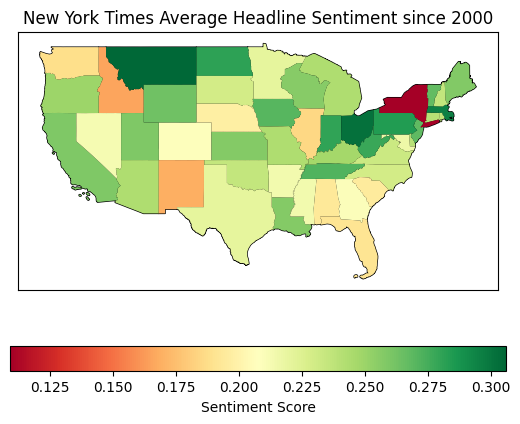

In [64]:

fig, ax = plt.subplots()
ax.title.set_text('New York Times Average Headline Sentiment since 2000')
#Only include continental US in plot
not_continental = ['Puerto Rico', 'Alaska', 'Hawaii']
plot_data = gdf_sentiment.loc[~gdf_sentiment['state'].isin(not_continental)]
# include a border
plot_data.plot(ax = ax, color='white', edgecolor='black')
# plot the map
plot_data.plot(
    ax = ax,
    column = 'headline_sentiment_score',
    cmap = 'RdYlGn',
    legend = True,
    legend_kwds={'label': 'Sentiment Score', 'orientation': 'horizontal'},
    figsize = (16, 14)
)

plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False)

save_path = 'DATA\sentiment_map.png'
plt.savefig(save_path)
plt.show()

In [65]:
non_geo_plots = facts.merge(geo_subjects[['fact_id', 'state']], on = ['fact_id'])
non_geo_plots.head()

,fact_id,publication_date,word_count,total_keywords,total_authors,words_in_headline,in_print,print_page,print_section,article_type_id,news_desk_id,section_name_id,headline_sentiment_score,state
0,1580,2018-10-26,2568,8,1,5,True,4.0,SR,33.0,50.0,37,0.99830,Colorado
1,1342,2011-04-17,189,3,1,9,False,NaN,None,NaN,NaN,42,0.00005,Arkansas
2,1645,2012-12-29,199,4,0,2,True,16.0,A,26.0,44.0,32,0.12163,New Jersey
3,1645,2012-12-29,199,4,0,2,True,16.0,A,26.0,44.0,32,0.12163,Connecticut
4,1238,2019-10-02,1382,6,1,12,True,12.0,A,29.0,56.0,57,0.03309,Arizona


In [69]:
non_geo_plots['publication_date'] = pd.to_datetime(non_geo_plots['publication_date'])
non_geo_plots['publication_year'] = non_geo_plots['publication_date'].dt.year
non_geo_plots.groupby('in_print')['headline_sentiment_score'].mean()


in_print
False    0.215143
True     0.249238
Name: headline_sentiment_score, dtype: float32